# BEES3041: Modelling the photosynthetic response to environmental conditions

![](data/logo.jpeg)

# Introduction

In this lab we are going to explore the C~3~ leaf-level photosynthesis model proposed by @Far80 and use this to simulate photosynthesis at leaf, ecosystem and global scales. The model is central to all land schemes embedded in coupled-climate models and predicts that photosynthesis is limited by the slowest of three biochemical processes: 

  1. The maximum rate of Rubisco-catalysed carboxylation
  2. The rate of ribulose 1,5-bisphosphate (RuBP) regeneration via electron transport 
  3. The rate of RuBP regeneration via triose phosphate utilisation 

In this practical we are only going to consider the first two limitations. There a number of great papers which cover this subject in detail, see for example, @Ber13, @Med02 and @Sha85.

We are going to use the photosynthesis model to:

* learn how leaf-level photosynthesis responds to changes in the environmental forcing (photosynthetically active radiation, temperature and carbon dioxide).
* simulate GPP at the ecosystem-scale (~1 km^2) using FLUXNET (eddy covariance) meteorological data.
* build a simpler GPP model and apply this at the ecosystem scale.

From playing with these model we should start to see the key assumptions that our models make. We should also begin to identify the key weakness in our approach as we apply the model at different scales. We should also start to build an understanding that would allow us to predict how vegetation will respond to global change.

***

# Temperature responses of model parameters

Let's start by exploring the response of the model to temperature. First we need to generate some temperature data:

In [1]:
%matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("python")
from farq import FarquharC3
import constants as c
import parameters as p

In [2]:
Tleaf = np.arange(0, 50.0+1.0) + c.DEG_2_KELVIN

In [3]:
print(Tleaf)

[273.15 274.15 275.15 276.15 277.15 278.15 279.15 280.15 281.15 282.15
 283.15 284.15 285.15 286.15 287.15 288.15 289.15 290.15 291.15 292.15
 293.15 294.15 295.15 296.15 297.15 298.15 299.15 300.15 301.15 302.15
 303.15 304.15 305.15 306.15 307.15 308.15 309.15 310.15 311.15 312.15
 313.15 314.15 315.15 316.15 317.15 318.15 319.15 320.15 321.15 322.15
 323.15]


The photosynthesis model has two major parameters, the potential rate of electron transport (Jmax) and the maximum rate of Rubisco activity (Vcmax). Both of these parameters vary as a function of temperature, let's plot them. I've copied the function calls from photosynthes.R:

In [4]:
F = FarquharC3(peaked_Jmax=True, peaked_Vcmax=True, gs_model="medlyn")

In [6]:
Vcmax = F.peaked_arrh(p.Vcmax25, p.Eav, Tleaf, p.deltaSv, p.Hdv)
Jmax = F.peaked_arrh(p.Jmax25, p.Eaj, Tleaf, p.deltaSj, p.Hdj)


<IPython.core.display.Javascript object>


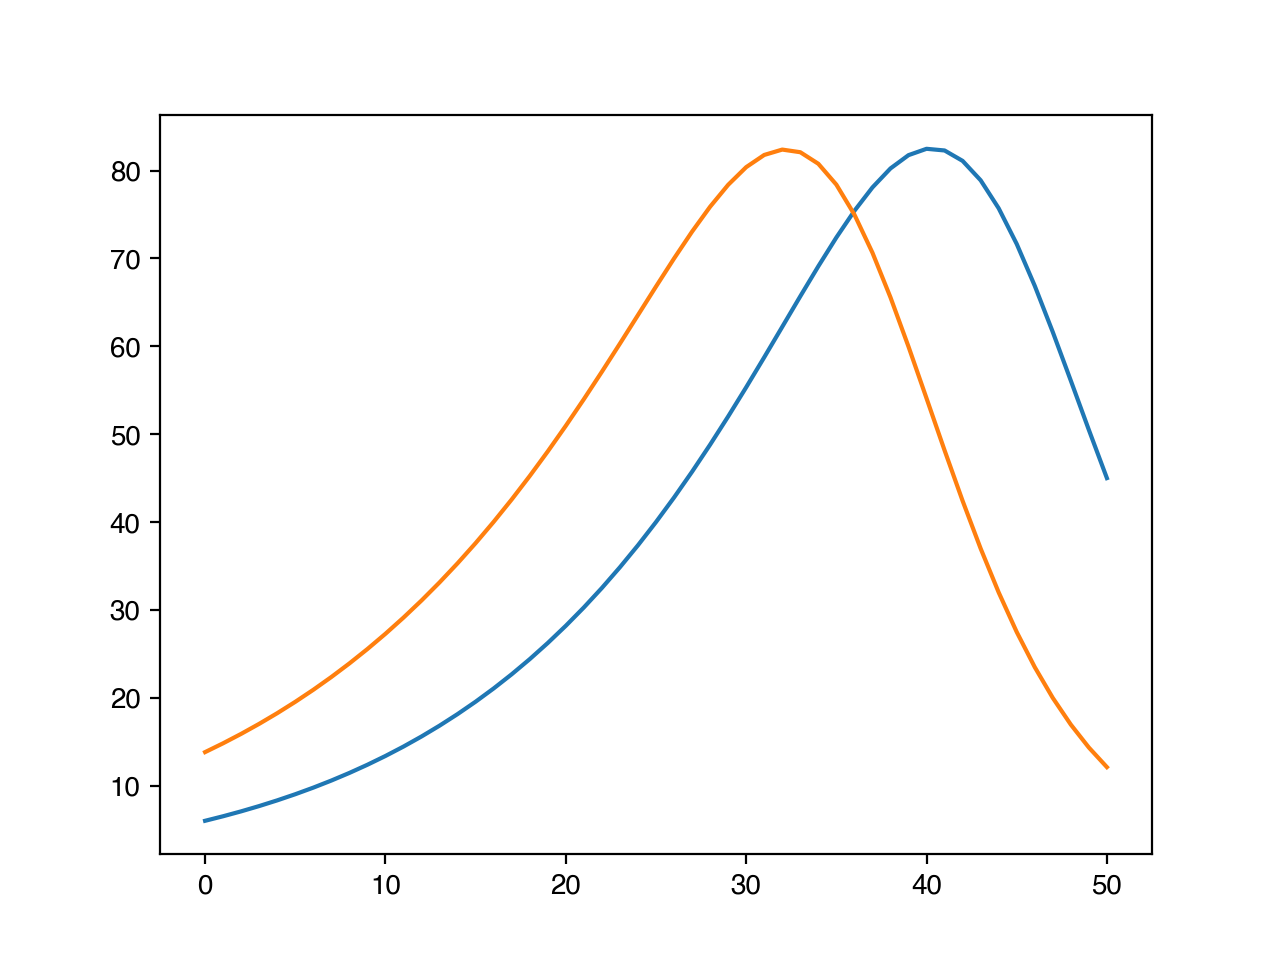

In [7]:
plt.plot(Tleaf-c.DEG_2_KELVIN, Vcmax)
plt.plot(Tleaf-c.DEG_2_KELVIN, Jmax)
plt.show()